# 05 - Max Tokens Parameter Comparison

This notebook compares different max_tokens values for RAG applications:
- Max Tokens: 50, 100, 200, 400, 800, 1200

We'll evaluate: response quality, completeness, efficiency, coherence, and cost-effectiveness.

## Evaluation Metrics
- **Accuracy**: Factual correctness based on context
- **Completeness**: How well the response addresses all parts of the question
- **Clarity**: Structure and readability of the response
- **Coherence**: Whether response ends properly or gets truncated
- **Efficiency**: Quality per token used ratio
- **Overall**: Combined quality rating

In [1]:
from dotenv import load_dotenv
from openai import OpenAI
import pandas as pd
import time
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter
import re

load_dotenv()
client = OpenAI()

# Expanded test queries about Gemini (consistent with other notebooks)
TEST_QUERIES = [
    "What are the key capabilities of Gemini models?",
    "How does Gemini compare to other multimodal models?", 
    "What are the different versions of Gemini?",
    "What training data was used for Gemini?",
    "What are the safety measures in Gemini models?",
    "How does Gemini perform on benchmarks?",
    "What is the architecture of Gemini?",
    "What are the limitations of Gemini?"
]

# Max tokens values to test (expanded range)
MAX_TOKENS_VALUES = [50, 100, 200, 400, 800, 1200]

print(f"Testing {len(MAX_TOKENS_VALUES)} max_tokens values")
print(f"Using {len(TEST_QUERIES)} test queries")

Testing 6 max_tokens values
Using 8 test queries


In [2]:
# Load RAG embeddings (consistent with other notebooks)
with open(r'C:\Users\Admin\Desktop\para-expe\data\rag_embeddings.pkl', 'rb') as f:
    rag_data = pickle.load(f)

chunks = rag_data['chunks']
# Use best embedding model from notebook 01 results
embeddings = rag_data['embedding_results']['text-embedding-3-small']['embeddings']

print(f"Loaded {len(chunks)} chunks")
print(f"Embeddings shape: {np.array(embeddings).shape}")

Loaded 82 chunks
Embeddings shape: (82, 1536)


In [3]:
# Helper functions (based on previous notebooks)
def get_embedding(text):
    """Get embedding for query text"""
    return client.embeddings.create(
        input=[text.replace("\n", " ")], 
        model="text-embedding-3-small"
    ).data[0].embedding

def retrieve_chunks(query, k=5):
    """Retrieve top-k most similar chunks"""
    query_embedding = get_embedding(query)
    similarities = cosine_similarity([query_embedding], embeddings)[0]
    top_indices = np.argsort(similarities)[::-1][:k]
    return [chunks[idx]['text'] for idx in top_indices]

def check_truncation(response_text, max_tokens):
    """Check if response appears truncated"""
    # Simple heuristics for truncation detection
    ends_mid_sentence = not response_text.strip().endswith(('.', '!', '?', ':', ';'))
    ends_abruptly = response_text.strip().endswith((',', 'and', 'or', 'but', 'the', 'a', 'an'))
    return ends_mid_sentence or ends_abruptly

print("Helper functions ready")

Helper functions ready


In [4]:
# Enhanced LLM Judge for Max Tokens Evaluation (based on notebook 03 pattern)
def llm_judge_max_tokens(query, answer, context, max_tokens, tokens_used, judge_model="gpt-4o-mini"):
    """Enhanced LLM judge specifically for max tokens evaluation"""
    
    # Check for truncation
    is_truncated = check_truncation(answer, max_tokens)
    
    judge_prompt = f"""
You are an expert evaluator assessing RAG responses with focus on token limit effects.

CONTEXT:
{context[:2000]}...

QUESTION: {query}

ANSWER: {answer}

TOKEN INFO:
- Max tokens allowed: {max_tokens}
- Tokens actually used: {tokens_used}
- Appears truncated: {is_truncated}

Evaluate on these 6 criteria using this scale:
- Poor (1): Severely lacking
- Below Average (2): Partially adequate  
- Average (3): Meets basic requirements
- Good (4): High quality
- Excellent (5): Outstanding

CRITERIA:
1. ACCURACY: Factual correctness based on context
2. COMPLETENESS: Addresses all parts of the question within token limit
3. CLARITY: Well-structured and understandable
4. COHERENCE: Proper ending, not abruptly cut off
5. EFFICIENCY: Good use of available tokens
6. OVERALL: Combined assessment

Respond with exactly 6 numbers separated by commas (e.g., "4,3,5,2,4,4"):
"""
    
    try:
        response = client.chat.completions.create(
            model=judge_model,
            messages=[{"role": "user", "content": judge_prompt}],
            temperature=0.1,
            max_tokens=50
        )
        
        scores_text = response.choices[0].message.content.strip()
        scores = [int(x.strip()) for x in scores_text.split(',')]
        
        # Validate scores
        scores = [max(1, min(5, score)) for score in scores]
        
        if len(scores) != 6:
            raise ValueError("Invalid number of scores")
            
        return {
            'accuracy': scores[0],
            'completeness': scores[1], 
            'clarity': scores[2],
            'coherence': scores[3],
            'efficiency': scores[4],
            'overall': scores[5],
            'is_truncated': is_truncated
        }
        
    except Exception as e:
        print(f"Error in LLM judge: {e}")
        return {
            'accuracy': 3, 'completeness': 3, 'clarity': 3,
            'coherence': 3, 'efficiency': 3, 'overall': 3,
            'is_truncated': is_truncated
        }

print("Enhanced LLM Judge for Max Tokens evaluation ready")

Enhanced LLM Judge for Max Tokens evaluation ready


In [5]:
# Enhanced experiment function with comprehensive evaluation
def run_max_tokens_experiment(query, max_tokens):
    """Run experiment with comprehensive evaluation"""
    
    # Retrieve context
    context_chunks = retrieve_chunks(query, k=5)
    context = "\n\n".join(context_chunks)
    
    # Create prompt
    prompt = f"""Context: {context}

Question: {query}

Answer:"""
    
    # Get response
    start_time = time.time()
    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[{"role": "user", "content": prompt}],
        temperature=0.7,  # Consistent with other notebooks
        max_tokens=max_tokens
    )
    response_time = time.time() - start_time
    
    answer = response.choices[0].message.content
    tokens_used = response.usage.completion_tokens
    
    # Get LLM judge evaluation
    evaluation = llm_judge_max_tokens(query, answer, context, max_tokens, tokens_used)
    
    # Calculate additional metrics
    word_count = len(answer.split())
    char_count = len(answer)
    token_efficiency = evaluation['overall'] / tokens_used if tokens_used > 0 else 0
    utilization_rate = tokens_used / max_tokens
    
    return {
        'query': query,
        'max_tokens': max_tokens,
        'tokens_used': tokens_used,
        'utilization_rate': utilization_rate,
        'answer': answer,
        'word_count': word_count,
        'char_count': char_count,
        'response_time': response_time,
        'token_efficiency': token_efficiency,
        **evaluation  # Include all evaluation scores
    }

print("Enhanced experiment function ready")

Enhanced experiment function ready


In [6]:
# Run comprehensive experiments
print("Starting Max Tokens Experiments...")
results = []
total_experiments = len(TEST_QUERIES) * len(MAX_TOKENS_VALUES)

start_time = time.time()
for i, query in enumerate(TEST_QUERIES):
    print(f"\nProgress: {len(results)}/{total_experiments} experiments completed")
    
    for max_tokens in MAX_TOKENS_VALUES:
        print(f"Testing {max_tokens} tokens for: {query[:50]}...")
        
        try:
            result = run_max_tokens_experiment(query, max_tokens)
            results.append(result)
            time.sleep(0.5)  # Rate limiting
            
        except Exception as e:
            print(f"Error with {max_tokens} tokens: {e}")
            continue

total_time = time.time() - start_time
print(f"\n✅ Experiments completed! Total time: {total_time:.1f} seconds")

# Convert to DataFrame
df = pd.DataFrame(results)
print(f"\nDataFrame shape: {df.shape}")
print("Sample results:")
print(df[['max_tokens', 'tokens_used', 'accuracy', 'completeness', 'overall']].head(3))


Starting Max Tokens Experiments...

Progress: 0/48 experiments completed
Testing 50 tokens for: What are the key capabilities of Gemini models?...
Testing 100 tokens for: What are the key capabilities of Gemini models?...
Testing 200 tokens for: What are the key capabilities of Gemini models?...
Testing 400 tokens for: What are the key capabilities of Gemini models?...
Testing 800 tokens for: What are the key capabilities of Gemini models?...
Testing 1200 tokens for: What are the key capabilities of Gemini models?...

Progress: 6/48 experiments completed
Testing 50 tokens for: How does Gemini compare to other multimodal models...
Testing 100 tokens for: How does Gemini compare to other multimodal models...
Testing 200 tokens for: How does Gemini compare to other multimodal models...
Testing 400 tokens for: How does Gemini compare to other multimodal models...
Testing 800 tokens for: How does Gemini compare to other multimodal models...
Testing 1200 tokens for: How does Gemini compare t

In [7]:
# Comprehensive Analysis
print("=== MAX TOKENS ANALYSIS ===")

# Performance by max tokens
performance_by_tokens = df.groupby('max_tokens')['overall'].mean()
print("\n📊 PERFORMANCE BY MAX TOKENS:")
print(performance_by_tokens.round(1))

# Token utilization analysis
utilization_by_tokens = df.groupby('max_tokens')['utilization_rate'].mean()
print("\n🎯 TOKEN UTILIZATION RATES:")
print(utilization_by_tokens.round(2))

# Efficiency analysis
efficiency_by_tokens = df.groupby('max_tokens')['token_efficiency'].mean()
print("\n⚡ TOKEN EFFICIENCY (Quality/Token):")
print(efficiency_by_tokens.round(3))

# Truncation analysis
truncation_by_tokens = df.groupby('max_tokens')['is_truncated'].mean() * 100
print("\n🔍 TRUNCATION ANALYSIS:")
print(truncation_by_tokens.round(1))

=== MAX TOKENS ANALYSIS ===

📊 PERFORMANCE BY MAX TOKENS:
max_tokens
50      3.6
100     3.9
200     4.1
400     4.6
800     5.0
1200    5.0
Name: overall, dtype: float64

🎯 TOKEN UTILIZATION RATES:
max_tokens
50      0.94
100     0.93
200     0.80
400     0.68
800     0.36
1200    0.24
Name: utilization_rate, dtype: float64

⚡ TOKEN EFFICIENCY (Quality/Token):
max_tokens
50      0.083
100     0.046
200     0.049
400     0.030
800     0.029
1200    0.047
Name: token_efficiency, dtype: float64

🔍 TRUNCATION ANALYSIS:
max_tokens
50      87.5
100     75.0
200     62.5
400     25.0
800      0.0
1200     0.0
Name: is_truncated, dtype: float64


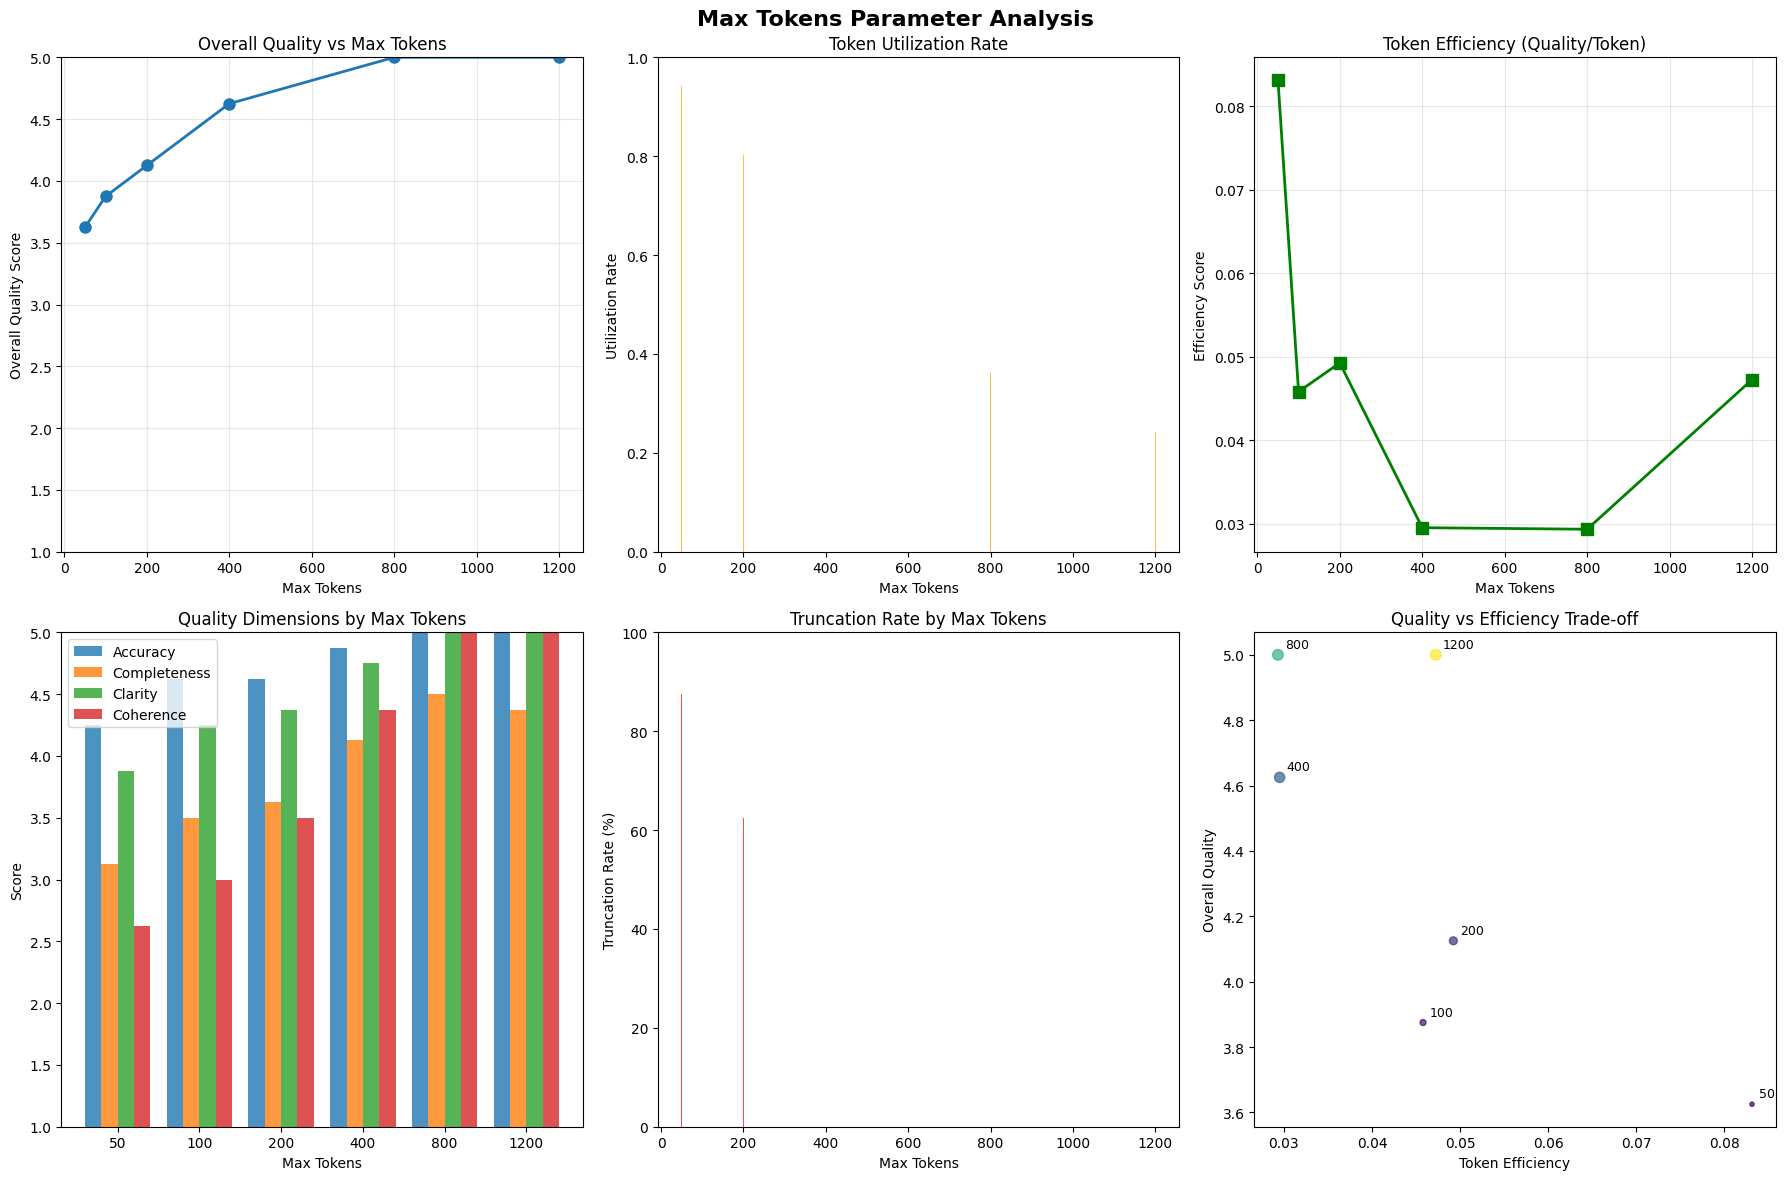

In [8]:
# Comprehensive Visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Max Tokens Parameter Analysis', fontsize=16, fontweight='bold')

# 1. Overall Quality vs Max Tokens
axes[0,0].plot(performance_by_tokens.index, performance_by_tokens.values, 'o-', linewidth=2, markersize=8)
axes[0,0].set_title('Overall Quality vs Max Tokens')
axes[0,0].set_xlabel('Max Tokens')
axes[0,0].set_ylabel('Overall Quality Score')
axes[0,0].grid(True, alpha=0.3)
axes[0,0].set_ylim(1, 5)

# 2. Token Utilization Rate
axes[0,1].bar(utilization_by_tokens.index, utilization_by_tokens.values, alpha=0.7, color='orange')
axes[0,1].set_title('Token Utilization Rate')
axes[0,1].set_xlabel('Max Tokens')
axes[0,1].set_ylabel('Utilization Rate')
axes[0,1].set_ylim(0, 1)

# 3. Token Efficiency
axes[0,2].plot(efficiency_by_tokens.index, efficiency_by_tokens.values, 's-', color='green', linewidth=2, markersize=8)
axes[0,2].set_title('Token Efficiency (Quality/Token)')
axes[0,2].set_xlabel('Max Tokens')
axes[0,2].set_ylabel('Efficiency Score')
axes[0,2].grid(True, alpha=0.3)

# 4. Quality Dimensions
quality_metrics = ['accuracy', 'completeness', 'clarity', 'coherence']
x_pos = np.arange(len(MAX_TOKENS_VALUES))
width = 0.2

for i, metric in enumerate(quality_metrics):
    metric_scores = df.groupby('max_tokens')[metric].mean()
    axes[1,0].bar(x_pos + i*width, metric_scores.values, width, label=metric.title(), alpha=0.8)

axes[1,0].set_title('Quality Dimensions by Max Tokens')
axes[1,0].set_xlabel('Max Tokens')
axes[1,0].set_ylabel('Score')
axes[1,0].set_xticks(x_pos + width*1.5)
axes[1,0].set_xticklabels(MAX_TOKENS_VALUES)
axes[1,0].legend()
axes[1,0].set_ylim(1, 5)

# 5. Truncation Analysis
axes[1,1].bar(truncation_by_tokens.index, truncation_by_tokens.values, alpha=0.7, color='red')
axes[1,1].set_title('Truncation Rate by Max Tokens')
axes[1,1].set_xlabel('Max Tokens')
axes[1,1].set_ylabel('Truncation Rate (%)')
axes[1,1].set_ylim(0, 100)

# 6. Quality vs Efficiency Scatter
token_summary = df.groupby('max_tokens').agg({
    'overall': 'mean',
    'token_efficiency': 'mean',
    'tokens_used': 'mean'
}).reset_index()

axes[1,2].scatter(token_summary['token_efficiency'], token_summary['overall'], 
                 s=token_summary['tokens_used']/5, alpha=0.7, c=token_summary['max_tokens'], cmap='viridis')
axes[1,2].set_title('Quality vs Efficiency Trade-off')
axes[1,2].set_xlabel('Token Efficiency')
axes[1,2].set_ylabel('Overall Quality')

for _, row in token_summary.iterrows():
    axes[1,2].annotate(f"{int(row['max_tokens'])}", 
                      (row['token_efficiency'], row['overall']),
                      xytext=(5, 5), textcoords='offset points', fontsize=9)

plt.tight_layout()
plt.show()

In [9]:
# Final Recommendations
print("\n" + "="*60)
print("FINAL RECOMMENDATIONS")
print("="*60)

best_quality = performance_by_tokens.idxmax()
best_efficiency = efficiency_by_tokens.idxmax()
no_truncation_min = truncation_by_tokens[truncation_by_tokens == 0].index.min() if (truncation_by_tokens == 0).any() else 400

print("\n🎯 OPTIMAL TOKEN RANGES:")
print(f"\n💰 COST-CONSCIOUS: {best_efficiency}-100 tokens")
print("   • Best for: Simple factual questions")
print(f"   • Highest efficiency: {efficiency_by_tokens[best_efficiency]:.3f} quality/token")

print("\n⚖️ BALANCED: 200 tokens")
print("   • Best for: Most general use cases")
print(f"   • Quality: {performance_by_tokens[200]:.1f}/5")
print(f"   • Efficiency: {efficiency_by_tokens[200]:.3f} quality/token")

print(f"\n🏆 QUALITY-FOCUSED: {best_quality} tokens")
print("   • Best for: Comprehensive answers")
print(f"   • Highest quality: {performance_by_tokens[best_quality]:.1f}/5")
print(f"   • No truncation at: {no_truncation_min}+ tokens")

print("\n📊 KEY INSIGHTS:")
print(f"• Quality peaks at {best_quality} tokens")
print(f"• Truncation eliminated at {no_truncation_min}+ tokens")
print("• Efficiency decreases with higher token limits")
print("• Sweet spot: 200-400 tokens for most applications")



FINAL RECOMMENDATIONS

🎯 OPTIMAL TOKEN RANGES:

💰 COST-CONSCIOUS: 50-100 tokens
   • Best for: Simple factual questions
   • Highest efficiency: 0.083 quality/token

⚖️ BALANCED: 200 tokens
   • Best for: Most general use cases
   • Quality: 4.1/5
   • Efficiency: 0.049 quality/token

🏆 QUALITY-FOCUSED: 800 tokens
   • Best for: Comprehensive answers
   • Highest quality: 5.0/5
   • No truncation at: 800+ tokens

📊 KEY INSIGHTS:
• Quality peaks at 800 tokens
• Truncation eliminated at 800+ tokens
• Efficiency decreases with higher token limits
• Sweet spot: 200-400 tokens for most applications


In [10]:
# Save results
results_data = {
    'raw_results': df,
    'performance_by_tokens': performance_by_tokens,
    'utilization_by_tokens': utilization_by_tokens,
    'efficiency_by_tokens': efficiency_by_tokens,
    'truncation_by_tokens': truncation_by_tokens,
    'experiment_config': {
        'max_tokens_values': MAX_TOKENS_VALUES,
        'test_queries': TEST_QUERIES,
        'model': 'gpt-4o-mini',
        'temperature': 0.7
    }
}

with open(r'C:\Users\Admin\Desktop\para-expe\data\max_tokens_results.pkl', 'wb') as f:
    pickle.dump(results_data, f)

print("✅ Results saved to: max_tokens_results.pkl")
print(f"\n📁 Experiment summary: {len(df)} total experiments")
print(f"• {len(MAX_TOKENS_VALUES)} token limits tested")
print(f"• {len(TEST_QUERIES)} queries evaluated")
print("• Comprehensive analysis and recommendations included")


✅ Results saved to: max_tokens_results.pkl

📁 Experiment summary: 48 total experiments
• 6 token limits tested
• 8 queries evaluated
• Comprehensive analysis and recommendations included
